In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from PIL import Image
import imutils
from keras import optimizers, Input
from keras.models import load_model
from keras.callbacks import EarlyStopping as es
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense, Conv2D, MaxPooling2D, Activation

In [2]:
# Now lets load the data
image_directory='/Users/lovishmiglani/archive (2)'
no_tumor_images=os.listdir(image_directory+ '/no')
yes_tumor_images=os.listdir(image_directory+ '/yes')

print('No Tumor: ', len(no_tumor_images))
print('Tumor: ',len(yes_tumor_images))

No Tumor:  1500
Tumor:  1503


In [3]:
dataset=[]
label=[]

In [4]:
def crop_brain_contour(image):
    image_width = 240
    image_height = 240

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    resized_image = cv2.resize(new_image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
    # normalize values
    normalized_image = resized_image / 255.

    return normalized_image


In [5]:
# Creating label for brain not having tumor
for image_name in no_tumor_images:
    if image_name.split('.')[-1].lower() == 'jpg':
        image_path = os.path.join(image_directory, 'no', image_name)
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            if image is not None:
                # Apply preprocessing to enhance the image
                preprocessed_image = crop_brain_contour(image)
                # Resize the image
                INPUT_SIZE = (224, 224)
                preprocessed_image = cv2.resize(preprocessed_image, dsize=INPUT_SIZE, interpolation=cv2.INTER_CUBIC)
                dataset.append(np.array(preprocessed_image))
            else:
                print(f"Failed to read image: {image_path}")
        else:
            print(f"Image not found: {image_path}")
        label.append(0)

In [6]:
# Creating label for brain having tumor
for image_name in yes_tumor_images:
    if image_name.split('.')[-1].lower() == 'jpg':
        image_path = os.path.join(image_directory, 'yes', image_name)
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            if image is not None:
                # Apply preprocessing to enhance the image
                preprocessed_image = crop_brain_contour(image)
                # Resize the image
                INPUT_SIZE = (224, 224)
                preprocessed_image = cv2.resize(preprocessed_image, dsize=INPUT_SIZE, interpolation=cv2.INTER_CUBIC)
                dataset.append(np.array(preprocessed_image))
            else:
                print(f"Failed to read image: {image_path}")
        else:
            print(f"Image not found: {image_path}")
        label.append(1)

In [7]:
label = np.array(label)
# print(label)
dataset = np.array(dataset)
print('Dataset: ', len(dataset))
# print(dataset)
print('Label: ', len(label))

Dataset:  3000
Label:  3000


In [8]:
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=2023)

In [9]:
input_shape = (224, 224, 3)

def transfer_learning(input_shape):
    new_input = Input(shape=(input_shape[0], input_shape[1], input_shape[2]))
    base_model = VGG16(include_top=False, input_tensor=new_input, weights='imagenet')
    model = Sequential()
    model.add(base_model)
    for layer in base_model.layers[:-2]:
        layer.trainable = False
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    model.layers[0].trainable = False
    adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    model.compile(
        loss='binary_crossentropy',
        optimizer=adam,
        metrics=['accuracy']
    )
    model.summary()
    return model

In [12]:
model = transfer_learning(input_shape)
# model.save('test_BT.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16320449 (62.26 MB)
Trainable params: 1605761 (6.13 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [10]:
input_shape = (224, 224, 3)

def transfer_learning(input_shape):
    new_input = Input(shape=(input_shape[0], input_shape[1], input_shape[2]))
    base_model = VGG16(include_top=False, input_tensor=new_input, weights='imagenet')
    
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))  # Updated to have a single unit for binary classification

    for layer in base_model.layers[:-2]:
        layer.trainable = False

    model.layers[0].trainable = False
    
    adam = tf.keras.optimizers.Adam(learning_rate=0.01)  # Updated optimizer
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=adam,
        metrics=['accuracy']
    )
    
    model.summary()
    return model

In [172]:
y_train = np.expand_dims(y_train, axis=-1) 
y_test = np.expand_dims(y_test, axis=-1)

In [78]:
es = EarlyStopping(
    monitor='val_loss',
    mode='max',
    restore_best_weights=True,
    patience=5
)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    verbose=1, 
                    validation_data=(X_test, y_test), 
                    callbacks=[es])

Epoch 1/50
75/75 [==============================] - 493s 7s/step - loss: 0.8961 - accuracy: 0.8429 - val_loss: 0.1402 - val_accuracy: 0.9533
Epoch 2/50
75/75 [==============================] - 729s 10s/step - loss: 0.1674 - accuracy: 0.9438 - val_loss: 0.2417 - val_accuracy: 0.9067
Epoch 3/50
75/75 [==============================] - 890s 12s/step - loss: 0.0620 - accuracy: 0.9800 - val_loss: 0.0933 - val_accuracy: 0.9683
Epoch 4/50
75/75 [==============================] - 875s 12s/step - loss: 0.0304 - accuracy: 0.9892 - val_loss: 0.1053 - val_accuracy: 0.9633
Epoch 5/50
75/75 [==============================] - 827s 11s/step - loss: 0.0184 - accuracy: 0.9933 - val_loss: 0.0853 - val_accuracy: 0.9783
Epoch 6/50
75/75 [==============================] - 776s 10s/step - loss: 0.0066 - accuracy: 0.9992 - val_loss: 0.0751 - val_accuracy: 0.9817
Epoch 7/50
75/75 [==============================] - 791s 11s/step - loss: 0.0136 - accuracy: 0.9946 - val_loss: 0.1795 - val_accuracy: 0.9517


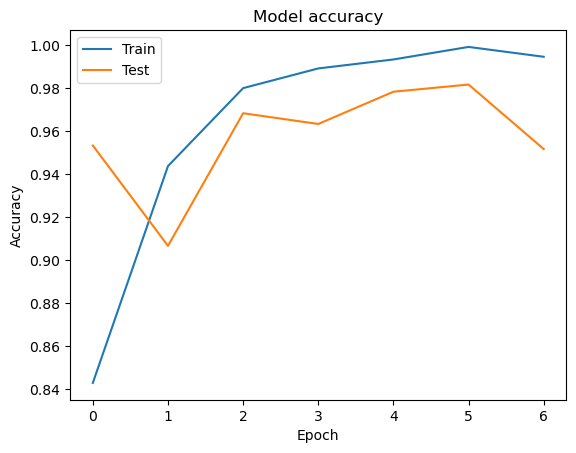

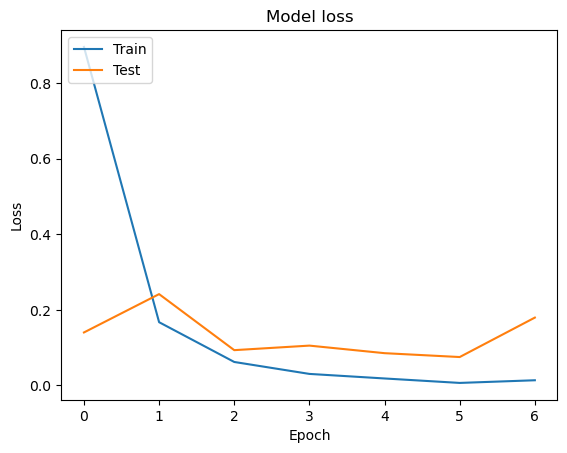

In [79]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [132]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)


19/19 - 162s - loss: 0.2417 - accuracy: 0.9067 - 162s/epoch - 9s/step
Test Accuracy: 0.9066666960716248


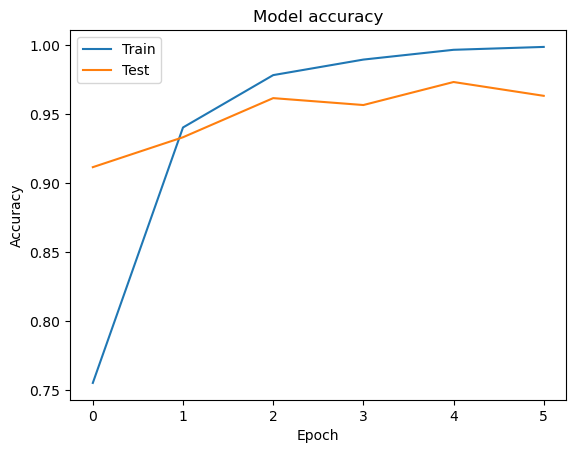

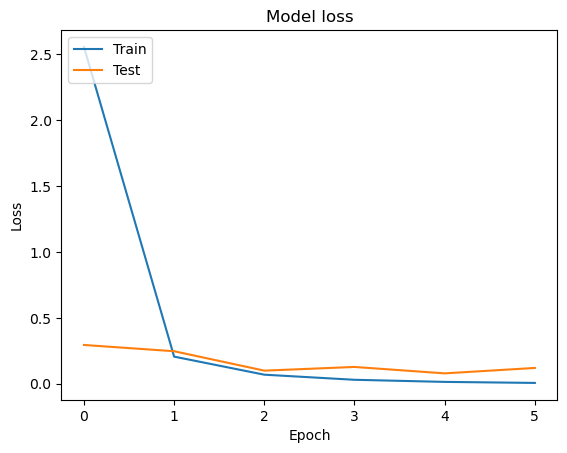

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [80]:
model.save('test_BT.h5')
model = load_model('/Users/lovishmiglani/test_BT.h5')

In [81]:
def make_prediction(img):
    input_img = np.expand_dims(img, axis=0)
    
    # Preprocess the input image
    input_img = preprocess_input(input_img)
    
    res = (model.predict(input_img) > 0.5).astype("int32")
    return res

In [10]:
def show_result(img):
    img_path = os.path.join(image_directory, 'pred', img)
    
    # Check if the image file exists
    if os.path.exists(img_path):
        # Read the image using cv2
        image = cv2.imread(img_path)
        
        # Check if the image is successfully read
        if image is not None:
            # Convert the image to an RGB PIL Image
            img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            
            # Resize the image
            img = img.resize((224, 224))
            
            # Convert the image back to a numpy array if needed
            img = np.array(img)
            
            plt.imshow(img)
            plt.show()
            pred = make_prediction(img)
            if pred:
                print("Tumor Detected")
            else:
                print("No Tumor")

In [11]:
show_result('/Users/lovishmiglani/Desktop/BrainTumourDetection-master/dataset/no/20 no.jpg')

NameError: name 'image_directory' is not defined